In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Cấu hình STL-10
STL10_CLASSES = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
MEAN = (0.4914, 0.4822, 0.4465) # Mean xấp xỉ của STL10/CIFAR
STD = (0.2023, 0.1994, 0.2010)  # Std xấp xỉ

def imshow(img, title=None):
    """Hàm để hiển thị Tensor ảnh đã normalize"""
    img = img.numpy().transpose((1, 2, 0)) # Chuyển từ (C, H, W) sang (H, W, C)
    
    # Un-normalize (nếu data đã normalize theo mean/std ở trên)
    # img = img * STD + MEAN 
    # Lưu ý: STL-10 raw load về thường là range [0, 255] hoặc [0, 1] tùy transform.
    # Để an toàn, ta clip về [0, 1]
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

print("Libraries imported.")

Libraries imported.


In [2]:
# Tải tập Train (có nhãn) và Unlabeled (không nhãn)
# Transform đơn giản chỉ để convert sang Tensor để vẽ
simple_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load dữ liệu (sẽ tự download vào folder ./data nếu chưa có)
train_set = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=simple_transform)
unlabeled_set = torchvision.datasets.STL10(root='./data', split='unlabeled', download=True, transform=simple_transform)

print(f"Labeled Train size: {len(train_set)}")
print(f"Unlabeled size: {len(unlabeled_set)}")
print(f"Image shape: {train_set[0][0].shape}")

Labeled Train size: 5000
Unlabeled size: 100000
Image shape: torch.Size([3, 96, 96])


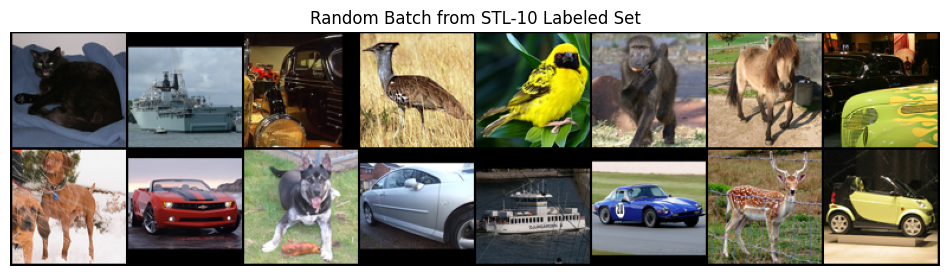

cat   ship  car   bird  bird  monkey horse car   dog   car   dog   car   ship  car   deer  car  


In [3]:
# Lấy một batch ảnh ngẫu nhiên từ tập Train
loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
dataiter = iter(loader)
images, labels = next(dataiter)

# Tạo lưới ảnh
plt.figure(figsize=(12, 6))
grid_img = torchvision.utils.make_grid(images, nrow=8, padding=2)

# Hiển thị
imshow(grid_img, title="Random Batch from STL-10 Labeled Set")
plt.show()

# In nhãn tương ứng
print(' '.join(f'{STL10_CLASSES[labels[j]]:5s}' for j in range(16)))

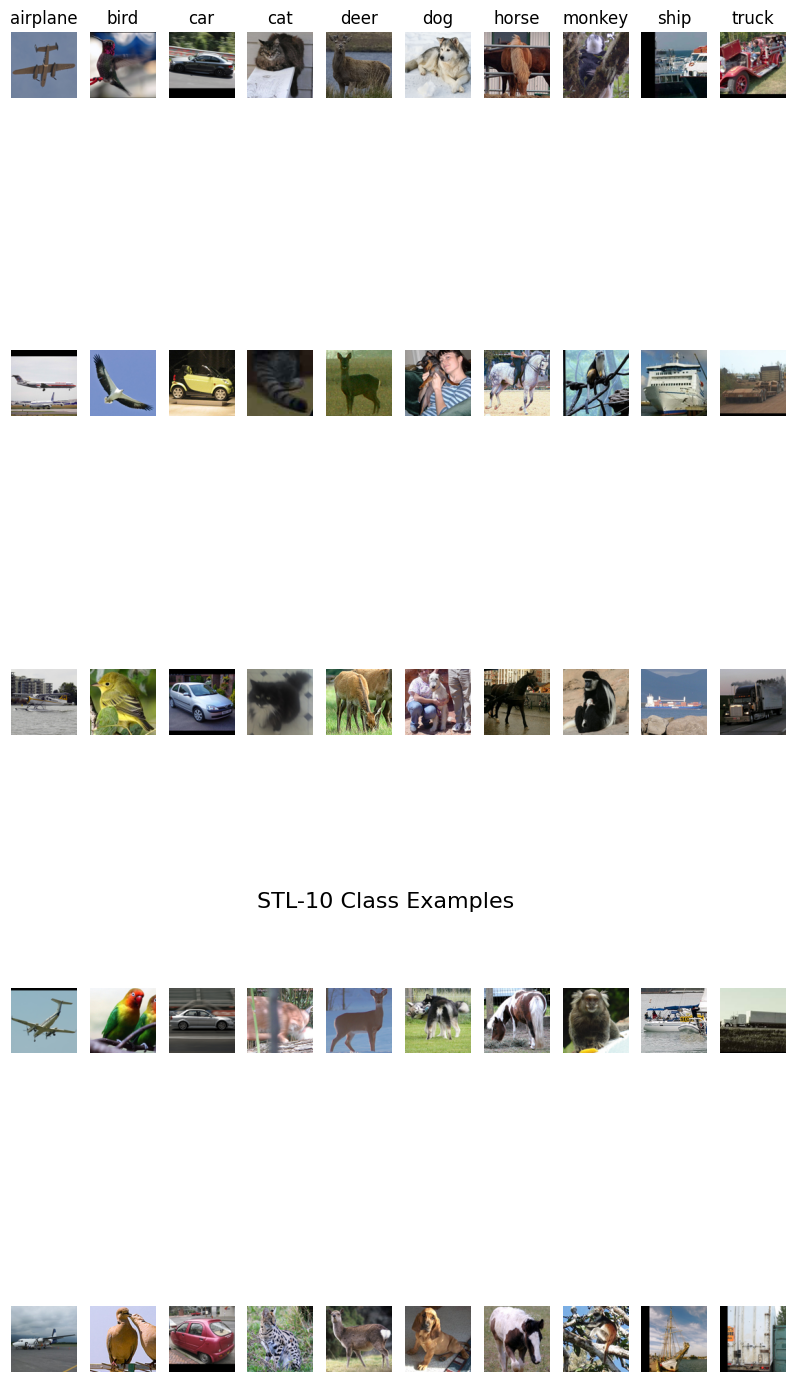

In [ ]:
num_classes = len(STL10_CLASSES)
samples_per_class = 5

plt.figure(figsize=(10, 20))

# Duyệt qua từng class để tìm ảnh
for y, cls in enumerate(STL10_CLASSES):
    idxs = np.flatnonzero(np.array(train_set.labels) == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        img, _ = train_set[idx]
        imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.suptitle("STL-10 Class Examples", y=0.92, fontsize=16)
plt.show()

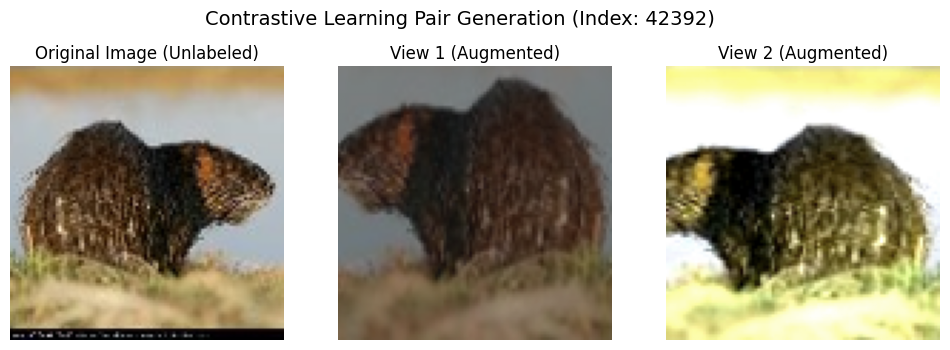

Nhận xét: Contrastive Learning buộc mô hình phải hiểu rằng View 1 và View 2 là cùng một vật thể bất chấp màu sắc hay góc nhìn.


In [5]:
# Định nghĩa bộ Transform mạnh giống SimCLR/MoCo
contrastive_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(96, scale=(0.2, 1.0)), # Crop ngẫu nhiên
    transforms.RandomHorizontalFlip(),                  # Lật ngang
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)      # Nhiễu màu
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),                  # Đen trắng
    transforms.ToTensor(),
])

# Lấy 1 ảnh từ tập Unlabeled
idx = np.random.randint(0, len(unlabeled_set))
original_tensor, _ = unlabeled_set[idx]

# Tạo 2 views
view_1 = contrastive_transform(original_tensor)
view_2 = contrastive_transform(original_tensor)

# Vẽ
plt.figure(figsize=(12, 4))

# Ảnh gốc
plt.subplot(1, 3, 1)
imshow(original_tensor, title="Original Image (Unlabeled)")

# View 1
plt.subplot(1, 3, 2)
imshow(view_1, title="View 1 (Augmented)")

# View 2
plt.subplot(1, 3, 3)
imshow(view_2, title="View 2 (Augmented)")

plt.suptitle(f"Contrastive Learning Pair Generation (Index: {idx})", fontsize=14)
plt.show()

print("Nhận xét: Contrastive Learning buộc mô hình phải hiểu rằng View 1 và View 2 là cùng một vật thể bất chấp màu sắc hay góc nhìn.")

/tmp/ipykernel_28763/4025523920.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=[STL10_CLASSES[i] for i in labels], palette="viridis")


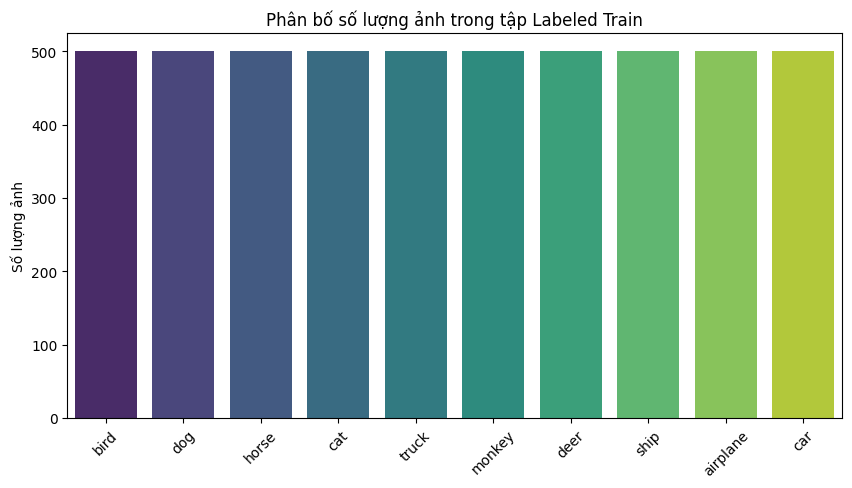

In [6]:
import seaborn as sns

labels = train_set.labels
plt.figure(figsize=(10, 5))
sns.countplot(x=[STL10_CLASSES[i] for i in labels], palette="viridis")
plt.title("Phân bố số lượng ảnh trong tập Labeled Train")
plt.ylabel("Số lượng ảnh")
plt.xticks(rotation=45)
plt.show()